tobac example: Cyclone tracking based on relative vorticity in kilometer-scale simulations 
==

This example notebook demonstrates the use of tobac to track cyclones or vortices of specific meteorological scale, based on the relative vorticity field in kilometer-scale simulations. Since such simulations are characterized by high frequencies in the vorticity field (especially in regions with complex terrain), tobac allows you to spectrally filter the input data by applying a bandpass filter on user-specified wavelengths. For more details about the used filter method and the **discrete cosine transformation** that is used to transfer input data to the spectral space is given in [Denis et al. 2002](https://journals.ametsoc.org/view/journals/mwre/130/7/1520-0493_2002_130_1812_sdotda_2.0.co_2.xml?tab_body=fulltext-display). 


The data used in this example is relative vorticity from a 4km [WRF](https://ncar.ucar.edu/what-we-offer/models/weather-research-and-forecasting-model-wrf) simulation in the Tibetan Plateau-Himalaya region. The target weather system, which we want to track here are shallow meso-scale vortices at 500 hpa. 


You can access the data from the "zenodo link", which is provided in the notebook (note that this only has to be done once for all the tobac example notebooks).

In [20]:
# Import a range of python libraries used in this notebook:
import xarray as xr
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Import tobac itself:
import tobac

In [3]:
# Disable a few warnings:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=FutureWarning, append=True)
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)

**Download example data:**  
The actual download is only necessary once for all example notebooks.

In [4]:
data_out= Path('../')

In [5]:
# # Download the data: This only has to be done once for all tobac examples and can take a while
# file_path='https://zenodo.org/record/3195910/files/climate-processes/tobac_example_data-v1.0.1.zip'
# #file_path='http://zenodo..'
# tempfile='temp.zip'
# print('start downloading data')
# request=urllib.request.urlretrieve(file_path,tempfile)
# print('start extracting data')
# shutil.unpack_archive(tempfile,data_out)
# #zf = zipfile.ZipFile(tempfile)
# #zf.extractall(data_out)
# os.remove(tempfile)
# print('data extracted')


In [6]:
# Load Data from downloaded file:
data_file = Path(data_out/ 'data'/ 'rv500hpa_CPTP-4km_ECMWF-ERA5_r1i1p1_NCAR-WRF421P_20080718-20080721.nc')
ds = xr.open_dataset(data_file)

# get variables
relative_vorticity = ds.relative_vorticity 
lats = ds.latitude
lons = ds.longitude


# check out what the data looks like
ds

<xarray.Dataset>
Dimensions:             (time: 96, latitude: 418, longitude: 982, south_north: 418, west_east: 982)
Coordinates:
  * time                (time) datetime64[ns] 2008-07-18 ... 2008-07-21T23:00:00
  * south_north         (south_north) int64 200 201 202 203 ... 614 615 616 617
  * west_east           (west_east) int64 200 201 202 203 ... 1179 1180 1181
  * latitude            (latitude) float32 25.26 25.3 25.33 ... 39.14 39.17 39.2
  * longitude           (longitude) float32 73.03 73.07 73.11 ... 111.9 112.0
Data variables:
    relative_vorticity  (time, latitude, longitude) float64 ...
    lat                 (south_north, west_east) float32 ...
    lon                 (south_north, west_east) float32 ...
Attributes:
    creation_date:  2022-02-26 18:50:55.104361
    author:         Julia Kukulies
    email:          julia.kukulies@gu.se
    simulation:     ERA5-driven WRF simulation without cumulus parametrization.

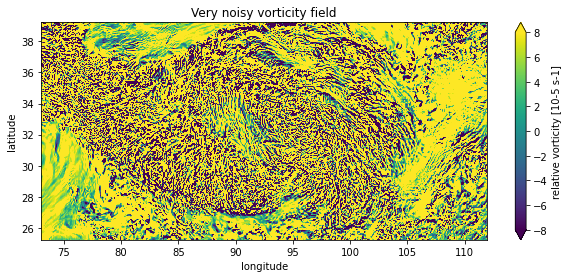

In [28]:
# checkout unfiltered relative vorticity field
plt.figure(figsize= (10,4))
m=relative_vorticity.sel(time=ds.time.values[10]).plot(vmin = -8, vmax = 8)
plt.title('Very noisy vorticity field')
plt.show()

In [29]:
#Set up directory to save output and plots:
savedir = Path('Save')
plotdir= Path('Plots')

savedir.mkdir(parents=True, exist_ok=True)
plotdir.mkdir(parents=True, exist_ok=True)

### Feature detection: 
    
Feature detection is performed based on the filtered relative vorticity field and your chosen set of thresholds. 


In [30]:
dxy, dt = tobac.utils.general.get_spacings(relative_vorticity)
# define exact grid spacing if known, since get_spacings() uses haversine approximation
dxy = 4000 

In [31]:
# Dictionary containing keyword arguments for feature detection step (Keywords could also be given directly in the function call).
parameters_features={}
parameters_features['position_threshold']='weighted_diff'
parameters_features['sigma_threshold']=0.5
parameters_features['min_num']= 5 
parameters_features['n_min_threshold']= 20
parameters_features['target']='maximum'
parameters_features['threshold']=[3, 5, 8 , 10 ]

In [32]:
# Perform feature detection:
print('starting feature detection')
Features=tobac.themes.tobac_v1.feature_detection_multithreshold(relative_vorticity, dxy = 4000 ,**parameters_features, wavelength_filtering = (400,1000))
Features.to_netcdf(savedir / 'Features.nc')
print('feature detection performed and saved')

starting feature detection
      frame  idx      hdim_1      hdim_2  num  threshold_value  feature  \
0         0   15   85.421135  461.424844  345                3        1   
1         0   36   94.388287  389.755255  113                3        2   
2         0   92  121.063744  317.556151  567                3        3   
3         0  167  152.503317  476.953244  572                3        4   
4         0  187  154.312465  954.013076  209                3        5   
...     ...  ...         ...         ...  ...              ...      ...   
2454     95  365  329.221852  146.736655   44                8     2455   
2455     95  383    5.422390  406.407131  367               10     2456   
2456     95  385   58.965620  246.934029  216               10     2457   
2457     95  402  204.513461  508.885020   92               10     2458   
2458     95  404  413.496592  427.516417  307               10     2459   

                     time              timestr   latitude   longitude  


### Check how the spectrally input field looks like


If you want to check how the filter and your filtered data looked like, you can do that by using the method tobac.utils.general.spectral_filtering() directly on your input data. This can be helpful in the development process, if you want to try out different ranges of wavelengths and see how this changes your data. In the example, we use use the spectral filtering method to remove wavelengths < 400 km and > 1000 km, because the focus is on meso-scale vortices. 

In [ ]:
# define minimum and maximum wavelength
lambda_min, lambda_max = 400, 1000

In [56]:
# use spectral filtering method on input data to check how the applied filter changes the data
relative_vorticity_meso, transfer_function = tobac.utils.general.spectral_filtering(dxy, relative_vorticity, lambda_min, lambda_max, return_transfer_function = True)

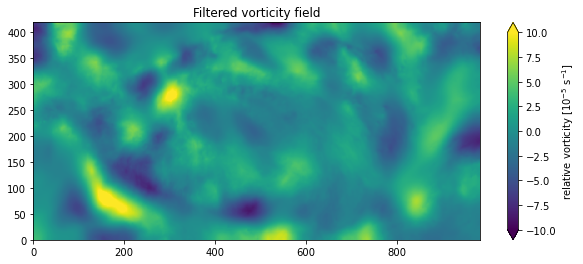

In [137]:
# checkout filtered relative vorticity field
plt.figure(figsize= (10,4))
plt.pcolormesh(relative_vorticity_meso[10], vmin = -10, vmax = 10)
plt.colorbar(label = 'relative vorticity [10$^{-5}$ s$^{-1}$]', extend = 'both')
plt.title('Filtered vorticity field')
plt.show()

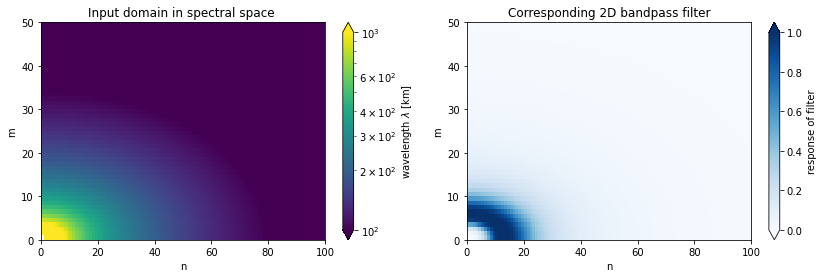

In [138]:
# checkout how the 2D filter looks like 
import matplotlib.colors as colors
plt.figure(figsize= (14,4))

ax = plt.subplot(1,2,1)
k = ax.pcolormesh(transfer_function[0],norm = colors.LogNorm(1e2, 1e3 ), shading = 'auto')
plt.colorbar(k, label = 'wavelength $\lambda$ [km]', extend = 'both')
ax.set_ylabel('m')
ax.set_xlabel('n')
# zoom into relevant wavelengths
ax.set_xlim([0,100])
ax.set_ylim([0,50])
ax.set_title('Input domain in spectral space ')

ax = plt.subplot(1,2,2)
tf = ax.pcolormesh(transfer_function[1] /np.nanmax(transfer_function[1]), vmin = 0, vmax =1, cmap = 'Blues')
plt.colorbar(tf, label = 'response of filter', extend = 'both')
ax.set_title('Corresponding 2D bandpass filter')
ax.set_ylabel('m')
ax.set_xlabel('n')
ax.set_xlim([0,100])
ax.set_ylim([0,50])


plt.show()

The response of the filter is 1 at locations, where wavelengths are within acceptable range and 0, when the wavelengths are outside of this range (here for: 400  km < $\lambda$ < 1000 km). The transition is smoothed. To better understand this transition, one could also look at the same filter in one dimension:

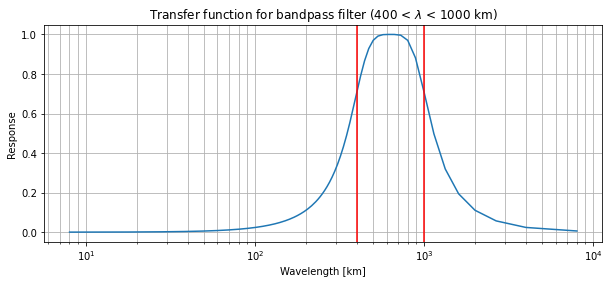

In [146]:
from scipy import signal 
# calculate filter according to lambda_min and lambda_max 
dxy = 4
b, a = signal.iirfilter(2, [1/lambda_max, 1/lambda_min], btype='band', ftype='butter', fs= 1/dxy, output ='ba')
w, h = signal.freqz(b, a, 1000, fs = 1/dxy)

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1, 1, 1)
plt.semilogx(1/w, abs(h))
#plt.plot(w, h)
ax.set_title('Transfer function for bandpass filter (400 < $\lambda$ < 1000 km)')
ax.set_xlabel('Wavelength [km]')
ax.set_ylabel('Response')
ax.axvline(400, c= 'r')
ax.axvline(1000, c= 'r')
ax.grid(which='both', axis='both')
plt.show()

**If you are happy with the applied filter and results of the feature detection..continue as usual:**

### Segmentation  

Segmentation is performed with watershedding based on the detected features and a single threshold value.

In [33]:
# Dictionary containing keyword options for the segmentation step:
parameters_segmentation={}
parameters_segmentation['target']='maximum'
parameters_segmentation['method']='watershed'
parameters_segmentation['threshold']= 1.5

In [34]:
# Perform segmentation and save results:
print('Starting segmentation based on relative vorticity.')
Mask_rv,Features_rv=tobac.themes.tobac_v1.segmentation(Features,relative_vorticity,dxy,**parameters_segmentation)
print('segmentation performed, start saving results to files')
Mask_rv.to_netcdf(savedir / 'Mask_Segmentation_rv.nc')              
Features_rv.to_netcdf(savedir/ 'Features_rv.nc')
print('segmentation performed and saved') 

Starting segmentation based on relative vorticity.
<xarray.DataArray 'relative_vorticity' (time: 96, latitude: 418, longitude: 982)>
array([[[  4.766225,   4.2929  , ...,  -1.162485,  -2.961178],
        [  5.813612,   4.697033, ...,  -2.417195,  -4.297156],
        ...,
        [ -0.955865,   5.145504, ...,   0.919581,  -0.418189],
        [ -9.211246, -14.757337, ...,  -0.46658 ,   1.053282]],

       [[  7.374629,   5.448922, ...,   9.250235,  22.251947],
        [  9.026978,   6.979799, ...,   0.581523,   5.478182],
        ...,
        [ -7.147407,   2.024936, ...,   6.417224,   2.363506],
        [-17.392601, -21.196777, ...,  -0.721217,  -0.487649]],

       ...,

       [[  5.533763,   4.442589, ...,  14.836962,  14.68639 ],
        [  5.599993,   4.621957, ...,  26.676411,   4.895739],
        ...,
        [-54.405624, -10.380352, ...,   9.327015,   8.324586],
        [-52.563953, -49.663475, ...,   8.960813,   8.430404]],

       [[  3.042372,   2.938492, ..., -69.444687, -21

### Trajectory linking

Features are linked into trajectories using the trackpy library (http://soft-matter.github.io/trackpy). This takes the feature positions determined in the feature detection step into account but does not include information on the shape of the identified objects.**

In [41]:
# Arguments for trajectory linking:
parameters_linking={}
parameters_linking['v_max']=80
parameters_linking['stubs']=2
parameters_linking['order']=1
parameters_linking['extrapolate']=1
parameters_linking['memory']=0
parameters_linking['adaptive_stop']=0.2
parameters_linking['adaptive_step']=0.95
parameters_linking['subnetwork_size']=1000
# require that the vortex has to persist during at least 12 hours 
parameters_linking['time_cell_min']= 12*dt 
parameters_linking['method_linking']= 'predict'

In [42]:
# Perform linking and save results to file:
Track=tobac.themes.tobac_v1.linking_trackpy(Features, relative_vorticity ,dt=dt,dxy=4000,**parameters_linking)
Track.to_netcdf(savedir/ 'Track.nc')

Frame 95: 23 trajectories present.


### Visualisation of tracks

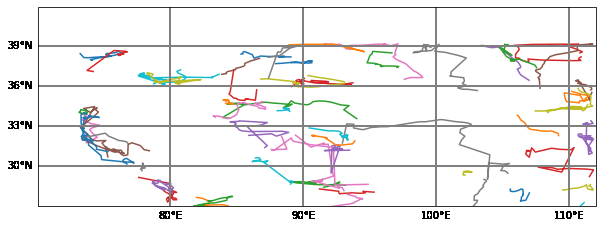

In [43]:
axis_extent= [70,112,27,40]
# Plot map with all individual tracks:
import cartopy.crs as ccrs
fig_map,ax_map=plt.subplots(figsize=(10,10),subplot_kw={'projection': ccrs.PlateCarree()})
ax_map=tobac.plot.map_tracks(Track,axis_extent=axis_extent,axes=ax_map)